### Ruben Abbou
## Smooth Cubic Splines

Data type which encapsulates the information associated with and Hermite cubic function (arrays for $x$, $y$, $dxdy$), in order to make a smooth interpolation of a given function.

In [1]:
%%capture
# import Tridiag data structure and solver
from ipynb.fs.full.TridiagonalSystemSolver import *

from scipy.interpolate import CubicHermiteSpline
import matplotlib.pyplot as plt
from numpy import zeros, sin, array, linspace, pi, sqrt, log10

The hermite basis for cubics on $[0,1]$ is expressed as follows:

$$q(x) = q(0)V_0(x) + q(1)V_1(x) + q'(0)S_0(x) + q'(1)S_1(x)$$
with 

\begin{align*}
V_0(x) &= 1-3x^2 +2x^3\\
V_1(x) &= 3x^2 -2x^3 \\
S_0(x) &= x(x - 1)^2 \\
S_1(x) &= x^2(x - 1).
\end{align*}

Therefore, a Hermite cubic $g$ on $I_i = [x_{i-1}, x_i]$ can be written as:

\begin{align*}
g(x)=\sum_{i=0}^{n}\left(y_i \mathcal{V}_{i}(x)+d y d x_i \mathcal{S}_{i}(x)\right)
\end{align*}
where for $i=0,\ldots,n$:

\begin{align*}
\mathcal{V}_{i}(x)=&\begin{cases}{V_1\left(\frac{x-x_{i-1}}{h_{i}}\right)} & {x \in I_{i}} \\
{V_0\left(\frac{x-x_{i}}{h_{i+1}}\right)} & {x \in I_{i+1}} \\
{0} & {\text { otherwise }}\end{cases}\\
\mathcal{S}_{i}(x)=&\begin{cases}{h_{i} S_1\left(\frac{x-x_{i-1}}{h_{i}}\right)} & {x \in I_{i}}
\\ {h_{i+1} S_0\left(\frac{x-x_{i}}{h_{i+1}}\right)} & {x \in I_{i+1}}
\\ {0} & {\text { otherwise}}\end{cases}\end{align*}

<!-- \begin{align*}
\mathcal{V}_{i}(x)=&\begin{cases}{3\left(\frac{x-x_{i-1}}{h_{i}}\right)^2-2\left(\frac{x-x_{i-1}}{h_{i}}\right)^3} & {x \in I_{i}} \\
{1-3\left(\frac{x-x_{i}}{h_{i+1}}\right)^2+2\left(\frac{x-x_{i}}{h_{i+1}}\right)^3} & {x \in I_{i+1}} \\
{0} & {\text { otherwise }}\end{cases}\\
\mathcal{S}_{i}(x)=&\begin{cases}{h_{i} \left(\frac{x-x_{i-1}}{h_{i}}\right)^2\left(\frac{x-x_{i-1}}{h_{i}} - 1 \right)} & {x \in I_{i}}
\\ {h_{i+1} \left(\frac{x-x_{i}}{h_{i+1}}\right)\left(\frac{x-x_{i}}{h_{i+1}} - 1 \right)^2} & {x \in I_{i+1}}
\\ {0} & {\text { otherwise}}\end{cases}\end{align*} -->

with $h_i = x_i-x_{i-1}$

Let $g_{i}''$ denote the jump in $g''$ at $x_i$ for $0<i<n$, i.e., $g_{i}''=g''(x_i+0)-g''(x_i-0)$. Since we require that g be $C^2$ at each interior knot, we need the jump in g'' to be zero at each of the n − 1 such knots. Therefore, we need to solve $g''$ such that

\begin{align*}
g''_i = &y_{i-1}\left(0-\frac{V_0''(1)}{h^2_i}\right)
+y_i\left(\frac{V_0''(0)}{h^2_{i+1}} - \frac{V_1''(1)}{h^2_i}\right)
+y_{i+1}\left(\frac{V_1''(0)}{h^2_{i+1}}-0\right) \\
&+ dydx_{i-1}\left(0-\frac{S_0''(1)}{h_i}\right)
+ dydx_{i}\left(\frac{S_0''(0)}{h_{i+1}}-\frac{S_1''(1)}{h_i}\right)
+ dydx_{i+1}\left(\frac{S_1''(0)}{h_{i+1}}-0\right) \\
= &y_{i-1}\left(0-\frac{6}{h^2_i}\right)
+y_i\left(-\frac{6}{h^2_{i+1}} + \frac{6}{h^2_i}\right)
+y_{i+1}\left(\frac{6}{h^2_{i+1}}-0\right) \\
&+ dydx_{i-1}\left(0-\frac{2}{h_i}\right)
+ dydx_{i}\left(-\frac{4}{h_{i+1}}-\frac{4}{h_i}\right)
+ dydx_{i+1}\left(-\frac{2}{h_{i+1}}-0\right) \\
= &0
\end{align*}

We can solve for $dxdy$ using a tridiagonal system.

In [2]:
def cubic_spline(x, y, dl, dr):
    '''
    Solves the system C*dydx = r and returns a cubic spline interpolation for 
    the given parameters
    Inputs:
        - x: a strictly increasing array
        - y: an array of values of the function at the points of p
        - dl: the derivative on the left
        - dr: the derivative on the right
    Output:
        - smooth cubic spline interpolation of f
    '''
    L = len(x)
    
    # initiate diagonals
    r, d, a, b = zeros(L), zeros(L), zeros(L-1), zeros(L-1)
    
    # initial parameters (set boundaries)
    r[0], r[-1] = dl, dr
    d[0], d[-1] = 1, 1
    a[0], b[-1] = 0, 0
    
    # step
    h = lambda k: x[k] - x[k-1]
    
    # make a, d, b, r
    for i in range(1, L-1):
        a[i] = -2 / h(i+1) - 0
        d[i] = -4 / h(i+1) - 4 / h(i)
        b[i-1] = 0 - 2 / h(i)
        r[i] = -(y[i-1] * (0 - 6 / h(i)**2) + \
                 y[i] * (-6 / h(i+1)**2 + 6 / h(i)**2) + \
                 y[i+1] * (6 / h(i+1)**2 - 0))
        
    # make tridiag matrix and solve for dydx
    C = Tridiag(d, a, b)
    dydx = gauss_tridiag_solve(C, r)
    
    # return spline function
    return CubicHermiteSpline(x, y, dydx)

### Case $f(x) = x^3$
The spline preserves cubics and is therefore exact for $f$.

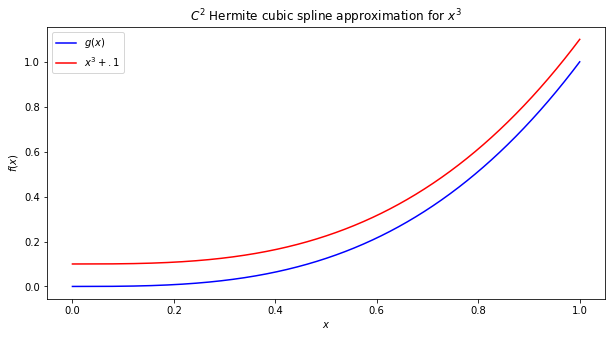

In [3]:
f = lambda x: x**3
x = [0, 0.1, 0.2, 0.5, 0.7, 1]
y = [f(i) for i in x]
dl = 0 # derivative at 0
dr = 3 # derivative at 1
g = cubic_spline(x, y, dl, dr)
mesh = linspace(0, 1, 1000)

plt.figure(figsize=(10, 5))
plt.plot(mesh, g(mesh), 'b', label = '$g(x)$')
plt.plot(mesh, f(mesh)+0.1, 'r', label = r'$x^3+.1$')
plt.title(r'$C^2$ Hermite cubic spline approximation for $x^3$')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend()
plt.show()

In [4]:
def convergence_study(a, b, dl, dr, f, sizes):
    '''
    Plots the log base 10 error of the Hermite Cubic approximation of a given function
    for a given interpolation mesh size
    Inputs:
        - a, b: approximation interval
        - dl, dr: left and right derivatives
        - f: function to interpolate
        - sizes: arry of mesh sizes
    '''
    errors = []
    
    # uniform partition
    mesh = linspace(a, b, 10000)
    
    for size in sizes:
        x = linspace(a, b, size+1)
        y = [f(i) for i in x]
        g = cubic_spline(x, y, dl, dr)
        
        # append log 10 absolute error
        errors.append(log10(sum(abs(f(mesh) - g(mesh)))))
        
    plt.figure(figsize=(10, 5))
    plt.plot(sizes, errors, 'g')
    plt.title(r'Connvergence of Hermite Cubic approximation')
    plt.xlabel(r'$log_{10}$(intervals)')
    plt.ylabel(r'$log_{10}$(error)')
    plt.xticks(mesh_sizes)
    plt.xlim(0, 35)
    plt.show()

### Case $\sin(x)$

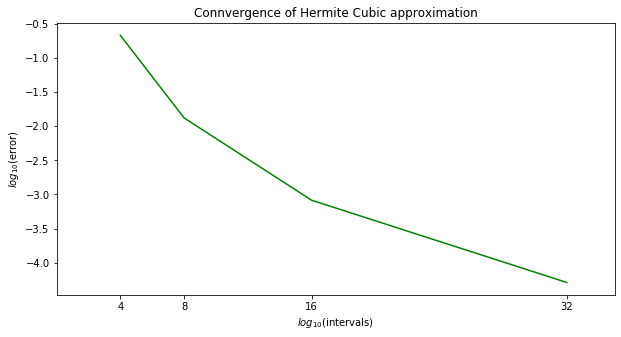

In [5]:
mesh_sizes = [2**i for i in range(2, 6)]
convergence_study(0, pi/2, 1, 0, lambda x: sin(x), mesh_sizes)

### Case $\sqrt{x}$

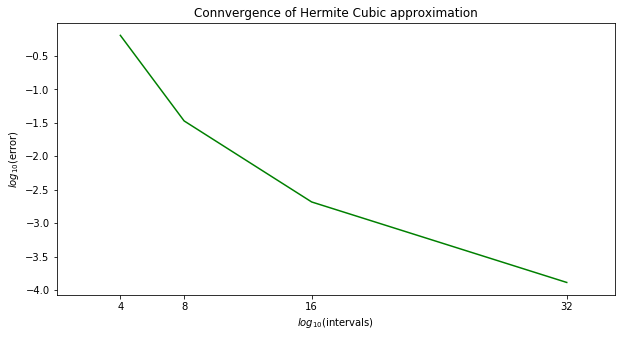

In [6]:
convergence_study(1, 4, 1/2, 1/4, lambda x: sqrt(x), mesh_sizes)